In [1]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
import pandas as pd

import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn.feature_extraction.text import CountVectorizer

import string

import matplotlib.pyplot as plt

from collections import Counter

In [3]:
replace_str1 = '<span class="css-1egxyvc" data-font-weight="bold">croissant</span>'
replace_str2 = '<span class="css-1egxyvc" data-font-weight="bold">croissants</span>'
replace_str3 = '<span class="css-1egxyvc" data-font-weight="bold">Croissant</span>'

In [4]:
reviews = []

with open("../archive/reviews.txt", "r") as the_file:
    while True:
        line = the_file.readline()
        if line == "":
            break
        elif len(line) > 3: # \n
            line = line.replace(replace_str1, "croissant")
            line = line.replace(replace_str2, "croissant")
            line = line.replace(replace_str3, "croissant")
            reviews.append(line)

print(len(reviews))

90


In [5]:
print(reviews[1:4])

['lost larson bakery : These are the best cinnamon rolls ever. The croissant are also delicious and the service is very efficient”\n', 'bang bang pie and biscuits : reminded me of a croissant) and light. The actual filling was very good and you can clearly taste”\n', 'good ambler : minutes. - Ham and cheese croissant: croissant was super flaky and the sesame seeds were a nice touch”\n']


In [6]:
# I like this version better but pandas words differently, so later we conform
dict_reviews = {review.split(' : ')[0]: review.split(' : ')[1] for review in reviews}

names = list(dict_reviews.keys())
names = [name.split("?hrid=")[0] for name in names]
names = [name.replace("%C3%A2", "a").replace("%C3%A9", "a") for name in names]
words = list(dict_reviews.values())
index = ['idx'+str(idx) for idx in range(0, len(names))]
dict_for_pd = {'idx': index, 'BakeryName': names, 'Review': words}

df = pd.DataFrame.from_dict(dict_for_pd)
df.set_index("idx", inplace = True)
df.head()

,BakeryName,Review
idx,,
idx0,hendrickx belgian bread crafter,The almond chocolate croissant and french coun...
idx1,lost larson bakery,These are the best cinnamon rolls ever. The cr...
idx2,bang bang pie and biscuits,reminded me of a croissant) and light. The act...
idx3,good ambler,minutes. - Ham and cheese croissant: croissant...
idx4,patisserie coralie,is a croissant desert. Search no more. Very fr...


In [7]:
# some peering
pd.options.display.max_colwidth = None
df[df['Review'].str.contains("flak")]

,BakeryName,Review
idx,,
idx3,good ambler,minutes. - Ham and cheese croissant: croissant was super flaky and the sesame seeds were a nice touch”\n
idx16,hoosier mama pie company,and cream admixture and a flaky buttery crust almost like that of a croissant. Indecisive and gluttonous as”\n
idx33,caffe umbria,"are the highlight of the show, you absolutely have to get a croissant - it was so flaky and buttery and the muffin was also moist and had a hint of cinnamon!!!”\n"
idx39,abc bakery and deli norridge,"of the seductive sweets. I chose a nutella croissant! Fluffy, flaky, sticky hazelnut spread glory. Yes”\n"


In [8]:
# hoosier mama is not a review on a croissant
# not a huge nutella fan, it's just sugar. too easy
# caffe umbria and good ambler are the winners based on this.
# but let's do more with these reviews
# while we r here. 

In [9]:
df[df['Review'].str.contains("artisan")]

,BakeryName,Review
idx,,


In [10]:
# tokenizing, filtering stop words, stemming, and lower casing

stop_words = set(stopwords.words("english"))
stop_words = stop_words.union({'!', '!!!', '!!!”', '!)', '!),', '!?', '!”', '"', '">', '.', "'", '\n'\
                               '&', '(', ')', '),', ').', '+', ',', '-', '--', '&', '...', '.”', '/',
                               '”', '…', '=', '/', '<', '..."'})

stemmer = SnowballStemmer('english')

In [11]:
df['Review_Prepped'] = df.Review.apply(lambda xyz: 
                                       [stemmer.stem(word.lower()) 
                                        for word in wordpunct_tokenize(xyz) 
                                        if word.lower() not in stop_words])

In [12]:
df.head()

,BakeryName,Review,Review_Prepped
idx,,,
idx0,hendrickx belgian bread crafter,The almond chocolate croissant and french country bread were quite authentic and wonderfully rustic.”\n,"[almond, chocol, croissant, french, countri, bread, quit, authent, wonder, rustic]"
idx1,lost larson bakery,These are the best cinnamon rolls ever. The croissant are also delicious and the service is very efficient”\n,"[best, cinnamon, roll, ever, croissant, also, delici, servic, effici]"
idx2,bang bang pie and biscuits,reminded me of a croissant) and light. The actual filling was very good and you can clearly taste”\n,"[remind, croissant, light, actual, fill, good, clear, tast]"
idx3,good ambler,minutes. - Ham and cheese croissant: croissant was super flaky and the sesame seeds were a nice touch”\n,"[minut, ham, chees, croissant, :, croissant, super, flaki, sesam, seed, nice, touch]"
idx4,patisserie coralie,"is a croissant desert. Search no more. Very friendly staff, great tea and coffee. A truly welcome addition to the neighborhood. Best of luck.”\n","[croissant, desert, search, friend, staff, great, tea, coffe, truli, welcom, addit, neighborhood, best, luck]"


In [13]:
df['Review_Prepped_str'] = df['Review_Prepped'].apply(lambda bbg: " ".join(bbg))
df['word_count'] = df['Review_Prepped_str'].apply(lambda x : nltk.FreqDist(nltk.word_tokenize(x))) #previously Review
df["freqdict"] = df.word_count.apply(lambda xxx: dict(xxx))

In [14]:
word_freq = pd.concat(map(pd.Series, df['word_count'])).index.value_counts().to_dict()
freq_for_plot = Counter(" ".join(df['Review_Prepped_str']).split()).most_common(30)

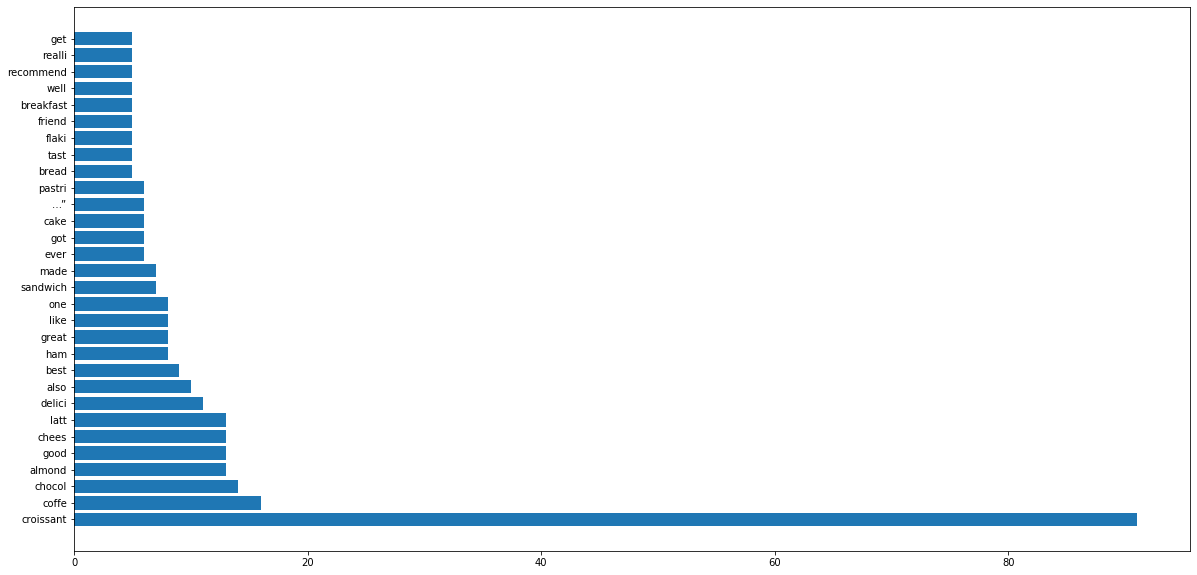

In [17]:
#below code is for words on x axis, tilted a bit; doesnt look good tho
#plt.bar(*zip(*freq_for_plot));
#plt.xticks(rotation = 75)
#plt.rcParams["figure.fizsize"] = (20, 3)

plt.barh(*zip(*freq_for_plot));
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()

In [16]:
df['label'] = ""
df.to_csv("unlabeled_df.csv")